## **Damage Detection Using Ensemble Learning: A Comprehensive Analysis and Implementation Notebook**
---



# Importing necessary packages



In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Activation
import tensorflow_datasets as tfds
# from keras.utils.vis_utils import plot_model

In [ ]:
import pandas as pd
from google.colab import data_table
data_table.enable_dataframe_formatter()
from google.colab import drive
import scipy.io
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.utils import class_weight

import pickle

# !pip install -Uqq ipdb
# import ipdb

In [ ]:
if tf.test.gpu_device_name():
  print('GPU is available')
  print(tf.config.list_physical_devices('GPU'))

GPU is available
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Importing the different datasets with distinct input features (PCA, RMSD, and extra)
In this section of the Python notebook, we will import various datasets that contain different sets of input features. These features include PCA (Principal Component Analysis), RMSD (Root Mean Square Deviation), and additional features.

In [ ]:
drive.mount('/content/drive')
mat_file_path = '/content/drive/MyDrive/Master Thesis/EMI-data/RMSDPCA4Regions10.mat'
data = scipy.io.loadmat(mat_file_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
print(data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'OutputTest', 'OutputTrain', 'OutputVal', 'inputTest', 'inputTrain', 'inputVal'])


# Allocating Key-Value Pairs from Mat Data to Tensors
In this section, we will focus on allocating key-value pairs from a Mat data file to tensors. The Mat file contains structured data with keys representing different features or variables, and values containing the corresponding data arrays. Our goal is to efficiently extract this data and convert it into tensor format, which is commonly used in deep learning frameworks like TensorFlow.

In [ ]:
input_Test=tf.convert_to_tensor(data['inputTest'])
input_Val=tf.convert_to_tensor(data['inputVal'])
input_train=tf.convert_to_tensor(data['inputTrain'])

output_Test=tf.convert_to_tensor(data['OutputTest'])
output_Val=tf.convert_to_tensor(data['OutputVal'])
output_train=tf.convert_to_tensor(data['OutputTrain'])


In [ ]:
# pd.DataFrame(input_Val)

# One-Hot Encoding of Training, Validation, and Test Datasets
In this section of the notebook, we will perform one-hot encoding on the training, validation, and test datasets. One-hot encoding is a common technique used to transform categorical variables into a binary representation that can be effectively used by machine learning algorithms.
By applying one-hot encoding, we will convert categorical variables in our datasets into binary columns, where each column represents a unique category. This transformation enables us to incorporate categorical information into our models accurately and efficiently.

In [ ]:
# One hot encoding of train, val and test dataset

regions=tf.gather(output_train,1,axis=1)
regions2=tf.gather(output_Val,1,axis=1)
regions3=tf.gather(output_Test,1,axis=1)

# pd.DataFrame(regions)
regions=tf.one_hot(regions,depth=4,axis=0)
regions2=tf.one_hot(regions2,depth=4,axis=0)
regions3=tf.one_hot(regions3,depth=4,axis=0)

regions=tf.transpose(regions)
regions2=tf.transpose(regions2)
regions3=tf.transpose(regions3)
# pd.DataFrame(regions)
# output_Val
# output_Test

# Separating Data for Classification and Regression Loss
In this section, we will split our dataset into two subsets: one for classification tasks and the other for regression tasks. This separation is crucial as different machine learning models and loss functions are often employed for these distinct problem types.

In [ ]:
# output_reg=output_train[:,[1,2]]
# output_reg = tf.gather(output_train, [1, 2], axis=1)
# output_log = tf.gather(output_train, 0, axis=1)
sever=tf.gather(output_train,0,axis=1)
sever = tf.cast(sever, dtype=tf.float32)
sever=tf.reshape(sever, shape=(-1, 1))
output_reg=tf.concat([sever,regions],axis=1)
# pd.DataFrame(output_reg)

sever=tf.gather(output_Val,0,axis=1)
sever = tf.cast(sever, dtype=tf.float32)
sever=tf.reshape(sever, shape=(-1, 1))
output_regVal=tf.concat([sever,regions2],axis=1)

sever=tf.gather(output_Test,0,axis=1)
sever = tf.cast(sever, dtype=tf.float32)
sever=tf.reshape(sever, shape=(-1, 1))
output_regTest=tf.concat([sever,regions3],axis=1)

# pd.DataFrame(output_regVal)
# pd.DataFrame(output_reg)
# output_regVal = tf.gather(output_Val, [1, 2], axis=1)
# output_logVal = tf.gather(output_Val, 0, axis=1)

# Selecting Input Features based on PCA Results and Variance
After applying PCA to our data, we have obtained the results that capture the variance explained by each principal component.

In [ ]:
# output_reg=output_train
# output_regVal=output_Val
# pd.DataFrame(output_regVal)
FeatureNum=58
startF=0
endF=51
input_train=tf.gather(input_train,(range(0,FeatureNum)),axis=1)
input_Val=tf.gather(input_Val,(range(0,FeatureNum)),axis=1)
input_Test=tf.gather(input_Test,(range(0,FeatureNum)),axis=1)
# pd.DataFrame(input_train)

In [ ]:
seed = 42
tf.random.set_seed(seed)

# # Shuffle the data tensors together
shuffled_indices = tf.range(start=0, limit=tf.shape(input_train)[0], dtype=tf.int32)
shuffled_indices = tf.random.shuffle(shuffled_indices, seed=seed)
input_train = tf.gather(input_train, shuffled_indices)
output_reg = tf.gather(output_reg, shuffled_indices)
# # output_log = tf.gather(output_log, shuffled_indices)


shuffled_indices = tf.range(start=0, limit=tf.shape(input_Val)[0], dtype=tf.int32)
shuffled_indices = tf.random.shuffle(shuffled_indices, seed=seed)
input_Val = tf.gather(input_Val, shuffled_indices)
output_regVal = tf.gather(output_regVal, shuffled_indices)

shuffled_indices = tf.range(start=0, limit=tf.shape(input_Test)[0], dtype=tf.int32)
shuffled_indices = tf.random.shuffle(shuffled_indices, seed=seed)
input_Test = tf.gather(input_Test, shuffled_indices)
output_regTest = tf.gather(output_regTest, shuffled_indices)

In [ ]:
output_sev_val=tf.gather(output_regVal,0 ,axis=1)
output_label_val=tf.gather(output_regVal,range(1,output_reg.shape[1]),axis=1)

output_sev=tf.gather(output_reg,0 ,axis=1)
output_label=tf.gather(output_reg,range(1,output_reg.shape[1]),axis=1)

output_sev_Test=tf.gather(output_regTest,0 ,axis=1)
output_label_Test=tf.gather(output_regTest,range(1,output_reg.shape[1]),axis=1)
# pd.DataFrame(output_label_val)
# pd.DataFrame(output_sev_val)
# output_logVal = tf.gather(output_logVal, shuffled_indices)

Adapting a Normalization Layer

In [ ]:
normalization_layer = tf.keras.layers.Normalization(axis=-1)
normalization_layer.adapt(input_train)


## Normalizing the inputs

In [ ]:
meanIn=tf.math.reduce_mean(input_train,axis=0)
varIn=tf.math.reduce_std(input_train,axis=0,keepdims=True)

input_train2=tf.math.divide(input_train-meanIn,varIn)
input_Val2=tf.math.divide(input_Val-meanIn,varIn)
input_Test2=tf.math.divide(input_Test-meanIn,varIn)

input_train2=input_train
input_Val2=input_Val
input_Test2=input_Test


To balance optimization across all tasks and prevent the regression output from dominating the total loss function, the regression output should be normalized, considering the classification outputs have a range of 0-1.

#Definnig Support Vector Machine(SVM) using sklearn

In [ ]:
# gamma=[0.0001,0.001,0.01,0.1,0.25,0.5,0.75,1,2,3,5,10,20,50,75,100]
# CC=[100,150,200,250,300,500,1000,5000,10000]

# CC=[0.75]
# gamma=['scale']
gamma=np.arange(0.0001,0.0015,0.0001)
# gamma=[0.005,0.0075,0.01,0.015,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1]
# gamma=np.arange(0.02,0.041,0.001)

# gamma=['scale']

# The optimum hyperparameters
CC=[100]
gamma=[0.0004]
#----------------------------
for j in gamma:

  for i in CC:

    #Step 1: transfor data to numpy array
    Y_train=tf.argmax(output_label,axis=1)
    Y_val=tf.argmax(output_label_val,axis=1)
    Y_Test=tf.argmax(output_label_Test,axis=1)

    Y_train=Y_train.numpy()
    inputs_train=input_train2.numpy()

    Y_val=Y_val.numpy()
    Y_Test=Y_Test.numpy()
    inputs_Val=input_Val2.numpy()
    inputs_Test=input_Test2.numpy()

    # Step 3: Create the SVM Model with RBF Kernel
    svm_model = SVC(C=i, kernel='rbf', degree=3, gamma=j,
                    coef0=0.0, shrinking=True, probability=True, tol=0.0001,
                    cache_size=200, class_weight='balanced', verbose=False, max_iter=-1, break_ties=False,
                    random_state=None)

    # clf = make_pipeline(StandardScaler(), svm_model)
    # Step 4: Train the Model and Monitor Validation Performance
    history = svm_model.fit(inputs_train, Y_train)

    # Step 5: Make Predictions on Test Data
    y_pred = svm_model.predict(inputs_Val)
    y_predTest = svm_model.predict(inputs_Test)

    # Step 6: Evaluate the Model on Test Data
    accuracy = accuracy_score(Y_val, y_pred)
    accuracy2 = accuracy_score(Y_Test, y_predTest)
    print('------------------------------------------------------')
    print('CC:',i,'--gama:',j,"Val Accuracy:", accuracy)
    print('******************************************************')
    print('CC:',i,'--gama:',j,"Test Accuracy:", accuracy2)
    print('------------------------------------------------------')

    # You can also print a detailed classification report for precision, recall, F1-score, etc.
    print("Test Classification Report:\n", classification_report(Y_val, y_pred))

------------------------------------------------------
CC: 100 --gama: 0.0004 Val Accuracy: 0.9684115523465704
******************************************************
CC: 100 --gama: 0.0004 Test Accuracy: 0.9273959341723137
------------------------------------------------------
Test Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        34
           1       1.00      0.99      1.00       387
           2       0.92      1.00      0.96       390
           3       1.00      0.89      0.94       297

    accuracy                           0.97      1108
   macro avg       0.98      0.97      0.97      1108
weighted avg       0.97      0.97      0.97      1108



In [ ]:
est=[50,100,200,300,500,600,800,1000,1500,5000]
# est=[500,600,700,1000]
est=[2]
# est=[2,3,5,10,20,30]
# est=[None]
# est=np.arange(1,20,1)

#The optimum hyperparameters
N_Tree=100
random_states=13

for i in est:
  #Step 1: transfor data to numpy array
  Y_train=tf.argmax(output_label,axis=1)
  Y_val=tf.argmax(output_label_val,axis=1)
  Y_Test=tf.argmax(output_label_Test,axis=1)

  Y_train=Y_train.numpy()
  inputs_train=input_train2.numpy()

  Y_val=Y_val.numpy()
  Y_Test=Y_Test.numpy()
  inputs_Val=input_Val2.numpy()
  inputs_Test=input_Test2.numpy()

  # Step 3: Create the SVM Model with RBF Kernel
  clf = RandomForestClassifier(n_estimators=N_Tree,criterion='log_loss', max_depth=None,
                               min_samples_split=2, min_samples_leaf=1,
                               min_weight_fraction_leaf=0.0, max_features='sqrt',
                               max_leaf_nodes=None, min_impurity_decrease=0.0,
                               bootstrap=True, oob_score=False, n_jobs=None,
                               random_state=random_states, verbose=0, warm_start=False,
                               class_weight='balanced', ccp_alpha=0.0, max_samples=None)

  # clf = make_pipeline(StandardScaler(), svm_model)
  # Step 4: Train the Model and Monitor Validation Performance
  history = clf.fit(inputs_train, Y_train)

  # Step 5: Make Predictions on Test Data
  y_pred = clf.predict(inputs_Val)
  y_predTest = clf.predict(inputs_Test)

  # Step 6: Evaluate the Model on Test Data
  accuracy = accuracy_score(Y_val, y_pred)
  accuracy2 = accuracy_score(Y_Test, y_predTest)
  print('------------------------------------------------------')
  print("number of Variable:",i,"Val Accuracy:", accuracy)
  print('******************************************************')
  print("Test Accuracy:", accuracy2)
  print('------------------------------------------------------')

  # You can also print a detailed classification report for precision, recall, F1-score, etc.
  print("Test Classification Report:\n", classification_report(Y_val, y_pred))

------------------------------------------------------
number of Variable: 2 Val Accuracy: 0.9088447653429603
******************************************************
Test Accuracy: 0.7676669893514037
------------------------------------------------------
Test Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        34
           1       1.00      1.00      1.00       387
           2       0.80      1.00      0.89       390
           3       0.99      0.66      0.80       297

    accuracy                           0.91      1108
   macro avg       0.95      0.92      0.92      1108
weighted avg       0.93      0.91      0.90      1108



definnig a MLP neural network using sklearn

# Defining ML model using functional API

##Defining a Multi-Task Loss Function
To address the issue of potential loss domination in our multi-task learning, we implement a custom loss function that combines two built-in loss functions using a linear combination. This approach allows us to fine-tune the weights and control the performance of the loss function through the learning curve.

Define a callback calss for evaluate the both loss in the model training

In [ ]:
# class LossHistoryCallback(tf.keras.callbacks.Callback):
#     def on_epoch_end(self, epoch, logs=None):
#         losses_outsev.append(logs['outsev_loss'])
#         losses_outlabel.append(logs['outlabel_loss'])

##Defining the model

In [ ]:
def base_model(input_layer,drop_rate=0.4,c=0.0,scale=True):
  # normalized_input = normalization_layer(input_layer)
  normalized_input = input_layer

  hidden = Dense(32,use_bias=False,kernel_regularizer=tf.keras.regularizers.l2(c))(normalized_input)
  hidden =BatchNormalization(scale=scale)(hidden)
  hidden =Activation('relu')(hidden)
  hidden= Dropout(drop_rate)(hidden)



  return hidden


###Defining the model architecture

In [ ]:
input_layer = tf.keras.layers.Input(shape=(input_train.shape[1],))

hidden=base_model(input_layer,drop_rate=0.45,c=0.0,scale=True)
hidden= Dropout(0.4)(hidden)
# output design
outLabel =Dense(4, name='outLabel',activation='softmax')(hidden)
outSev =Dense(1, name='outSev')(hidden)

# Create the model with two outputs
model = tf.keras.models.Model(inputs=input_layer, outputs=[outSev,outLabel])

# Define the loss functions for each output

num_classes=4
sample_weight = np.ones_like(Y_train,dtype=float)
for i in range(num_classes):
    class_samples = Y_train == i
    class_weight = len(Y_train) / (num_classes * np.sum(class_samples))
    sample_weight[class_samples] = class_weight



losses = {
    'outSev': 'mean_squared_error',
    'outLabel' : 'categorical_crossentropy'

}

metrics = {
    'outSev': [tf.keras.metrics.RootMeanSquaredError()],
    'outLabel' : 'accuracy'
}

opt=tf.optimizers.Adam()
# Compiling the model with multiple losses and loss weights
LossWeights={'outSev':0.05,
             'outLabel':0.95}

# model.compile(optimizer=opt, loss=losses,metrics=metrics)
model.compile(optimizer=opt, loss=losses,loss_weights=LossWeights,metrics=metrics)
# Print the model summary
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 58)]                 0         []                            
                                                                                                  
 dense_7 (Dense)             (None, 32)                   1856      ['input_5[0][0]']             
                                                                                                  
 batch_normalization_7 (Bat  (None, 32)                   128       ['dense_7[0][0]']             
 chNormalization)                                                                                 
                                                                                                  
 activation_7 (Activation)   (None, 32)                   0         ['batch_normalization_7[

In [ ]:
opt2=tf.optimizers.Adam(0.00001)
model.compile(optimizer=opt2, loss=losses,loss_weights=LossWeights,metrics=metrics)
pd.DataFrame(model.get_compile_config())
# pd.DataFrame(sample_weight)

,optimizer,loss,metrics,loss_weights,weighted_metrics,run_eagerly,steps_per_execution,jit_compile
module,keras.optimizers,NaN,NaN,NaN,None,None,None,None
class_name,Adam,NaN,NaN,NaN,None,None,None,None
config,"{'name': 'Adam', 'weight_decay': None, 'clipno...",NaN,NaN,NaN,None,None,None,None
registered_name,None,NaN,NaN,NaN,None,None,None,None
outSev,NaN,mean_squared_error,"[{'module': 'keras.metrics', 'class_name': 'Ro...",0.05,None,None,None,None
outLabel,NaN,categorical_crossentropy,accuracy,0.95,None,None,None,None


In [ ]:
history=model.fit(input_train,[output_sev,output_label],
                  validation_data=(input_Val,[output_sev_val,output_label_val]),
                  epochs=200, batch_size=2048,sample_weight=sample_weight)

Epoch 1/200
2/2 [==============================] - 2s 281ms/step - loss: 0.2009 - outSev_loss: 2.0761 - outLabel_loss: 0.1022 - outSev_outSev_outSev_root_mean_squared_error: 1.6274 - outLabel_accuracy: 0.9620 - val_loss: 0.3136 - val_outSev_loss: 2.9073 - val_outLabel_loss: 0.1771 - val_outSev_outSev_outSev_root_mean_squared_error: 1.7051 - val_outLabel_accuracy: 0.9260
Epoch 2/200
2/2 [==============================] - 0s 62ms/step - loss: 0.2031 - outSev_loss: 2.1669 - outLabel_loss: 0.0997 - outSev_outSev_outSev_root_mean_squared_error: 1.6415 - outLabel_accuracy: 0.9614 - val_loss: 0.3136 - val_outSev_loss: 2.9074 - val_outLabel_loss: 0.1771 - val_outSev_outSev_outSev_root_mean_squared_error: 1.7051 - val_outLabel_accuracy: 0.9260
Epoch 3/200
2/2 [==============================] - 0s 42ms/step - loss: 0.2252 - outSev_loss: 2.1039 - outLabel_loss: 0.1263 - outSev_outSev_outSev_root_mean_squared_error: 1.6233 - outLabel_accuracy: 0.9550 - val_loss: 0.3135 - val_outSev_loss: 2.9074 - 

#Evaluate the model using Learning Curve
In this section of the notebook, we will plot the learning curve to visualize the performance of our model as the training data size increases. The learning curve provides valuable insights into how well our model generalizes and whether it is underfitting or overfitting.

First we implementing learning plot.

In [ ]:
def LC_plt(train,val, StartPoint=1,train_Label='Training Loss',
           val_Label='Validation Loss',title='Training and Validation Loss',ylabel='Loss'):
  # Get the training and validation loss from the history object
  # Get the training and validation loss from the 50th epoch onwards
  training_loss = train[StartPoint:]  # Adjust index based on 0-indexing
  validation_loss = val[StartPoint:]  # Adjust index based on 0-indexing

  # Plot the learning curve
  epochs = range(StartPoint, len(training_loss) + StartPoint)  # Adjust the starting epoch
  plt.plot(epochs, training_loss, 'r', label=train_Label)
  plt.plot(epochs, validation_loss, 'b', label=val_Label)
  plt.title(title)
  plt.xlabel('Epochs')
  plt.ylabel(ylabel)
  plt.legend()
  plt.show()


In [ ]:
# import tensorflow as tf

# Assuming 'y_true' is your true labels and 'y_pred' are your model's predictions
# y_true = output_label_val
# y_pred = model.predict(input_Val)[1]
y_true=tf.argmax(output_label_Test,axis=1)
y_pred=tf.argmax(model.predict(input_Test)[1],axis=1)
# Initialize the Accuracy object
accuracy_obj = tf.keras.metrics.Accuracy()

# Update state with predictions and ground truth labels
accuracy_obj.update_state(y_true, y_pred)

# Get the accuracy value
accuracy_value = accuracy_obj.result().numpy()

print("Accuracy: ", accuracy_value)

33/33 [==============================] - 0s 2ms/step
Accuracy:  0.90416265


In [ ]:
losses_outlabel_train=history.history['outLabel_loss']
losses_outlabel_val=history.history['val_outLabel_loss']

losses_outsev_train=history.history['outSev_loss']
losses_outsev_val=history.history['val_outSev_loss']

losses__train=history.history['loss']
losses_val=history.history['val_loss']

accuracy_val=history.history['val_outLabel_accuracy']
accuracy_train=history.history['outLabel_accuracy']

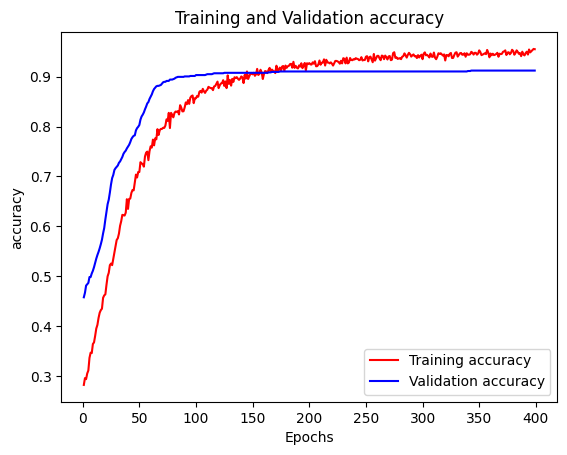

In [ ]:
LC_plt(accuracy_train,accuracy_val,StartPoint=1,train_Label='Training accuracy',
           val_Label='Validation accuracy',title='Training and Validation accuracy',ylabel='accuracy')

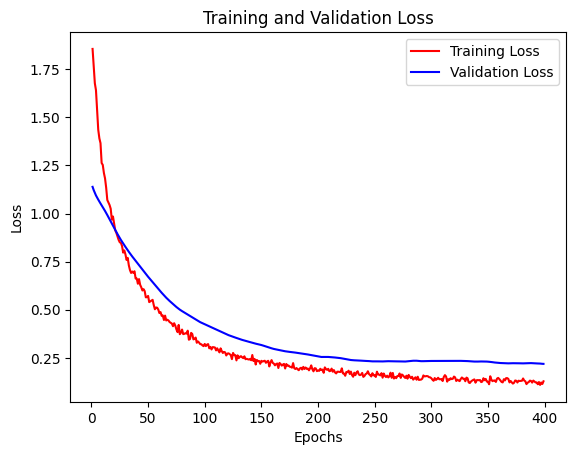

In [ ]:
LC_plt(losses_outlabel_train,losses_outlabel_val,StartPoint=1)

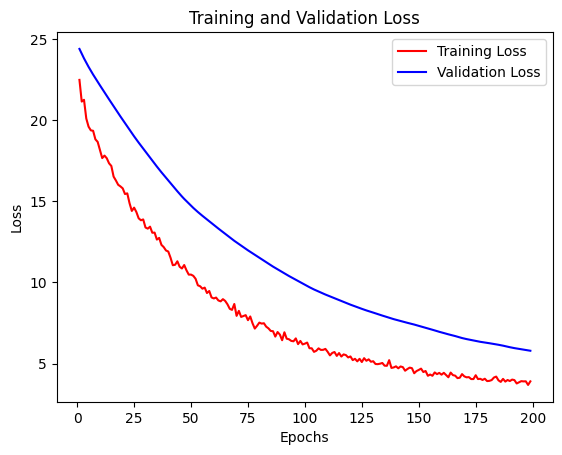

In [ ]:
LC_plt(losses_outsev_train,losses_outsev_val,StartPoint=1)

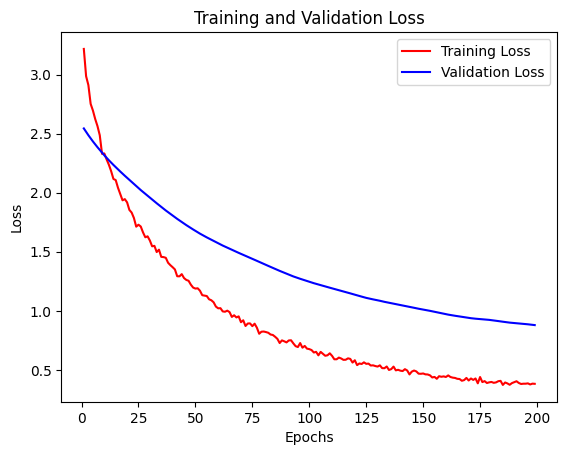

In [ ]:
LC_plt(losses__train,losses_val,StartPoint=1)